# 1. 환경 준비
- Batch size, Epoch 등 변경 가능.

## 데이터셋을 맨눈으로 보고 특징 판단

- 정상군의 폐는 검은색이 많은 편이고, 질환군의 폐는 거미줄같이 염증이 하얀색으로 퍼져 있는 부분이 많은 편이다.
- 21번 환자의 73번 데이터 같은 경우, 가운데에 철사로 보이는 물체가 감지됨. 이런 부분은 판정이 잘 되었는지 확인이 필요. 판정이 잘 되지 않았다면 가운데는 제외하고 ROI를 잡아야겠다.
- 판정 결과 확인요. 
- intervention: 23-78, 23-79, 23-80, 24-110, 25-116, 27-135, 28-141, 30-154, 37-186,38-194
- 

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import AveragePooling2D  
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 공통 파라미터

# X-ray image size
IMAGE_SIZE = [180, 180]

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 15

shuffle_buffer_size = 1000
num_parallel_calls = 2
convolution_filter_1 = 32
convolution_filter_2 = 64
convolution_filter_3 = 128
convolution_filter_4 = 256
dropout_rate_1 = 0.2
conv_activation = 'relu'
dense_activation = 'relu'
mid_activation = 'relu'
final_activation = 'sigmoid'
optimizer = 'adam'

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# data location
ROOT_PATH = r'C:\Users\user\Desktop\AIFFEL\Day26'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train/test/val 파일 개수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 조정된 train/test/val 파일 개수 확인
print(len(train_filenames))
print(len(val_filenames))

C:\Users\user\Desktop\AIFFEL\Day26
5216
624
16
4185
1047


In [4]:
# train data 안의 정상 이미지와 폐렴 이미지 개수
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
C:\Users\user\Desktop\AIFFEL\Day26\chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
C:\Users\user\Desktop\AIFFEL\Day26\chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images count in training set: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


# 2. 데이터 준비
- 육안으로 구분하기 어려운 미묘한 차이에 노이즈 등의 부수효과가 방해를 줄 수 있으므로 augmentation 도입은 신중하자.

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"    # 폐렴이면 양성(True), 노말이면 음성(False)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3)     # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)     # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)      # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)   # 이미지 읽기
    img = decode_img(img)    # 이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
# train dataset과 valdiation dataset을 만듬. AUTOTUNE 변수를 사용하면 더 빠르게 처리.
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

for image, label in train_ds.take(1):
    print('Image shape:', image.numpy().shape)
    print('label:', label.numpy())

Image shape: (180, 180, 3)
label: False


In [10]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [11]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    return image, label

def prepare_for_training(ds, shuffle_buffer_size = shuffle_buffer_size):
    
    # augment 적용 부분이 배치처리 함수에 추가.
    ds = ds.map(augment, num_parallel_calls = num_parallel_calls)
    
    # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  
    
    # epoch를 진행하면서 여러 번 데이터셋을 불러와도 사용할 수 있게 해줌.
    ds = ds.repeat()
    
    # BATCH_SIZE에서 정한 만큼의 배치로 주어짐.
    ds = ds.batch(BATCH_SIZE)
    
    # 학습데이터를 나눠서 읽음. 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화
- augmentation을 시도했다면 show_batch 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인.

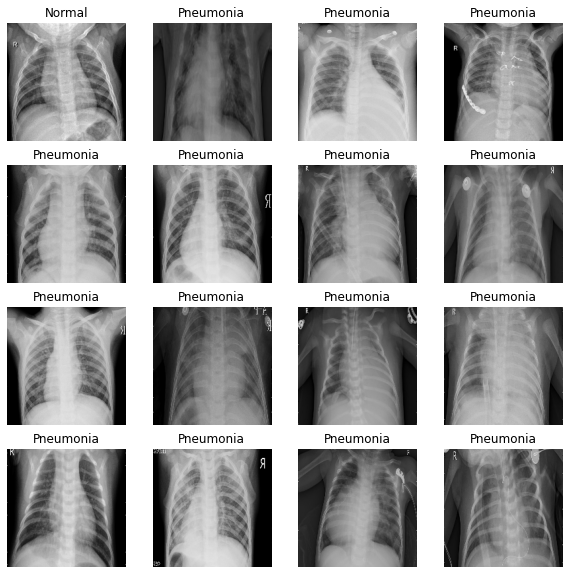

In [12]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줌.
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('Pneumonia')
        else: 
            plt.title('Normal')
        plt.axis('off')
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링
- Convolution filter, Channel number, activation, model structure 등 변경 시도.
- Batch normalization 사용 유/무
- Dropout 사용 유/무, 사용시 비율 변경.

In [13]:
# Convolution block
def conv_block(filters, conv_activation):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = conv_activation, padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = conv_activation, padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D()
    ])
    
    return block

# Dense block
def dense_block(units, dropout_rate, dense_activation):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = dense_activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [14]:
def build_model(mid_activation, convolution_filter_1, convolution_filter_2, convolution_filter_3, convolution_filter_4, conv_activation, dense_activation, final_activation):
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation = mid_activation, padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = mid_activation, padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(convolution_filter_1, conv_activation),
        conv_block(convolution_filter_2, conv_activation),
        
        conv_block(convolution_filter_3, conv_activation),
        tf.keras.layers.Dropout(dropout_rate_1),
        
        conv_block(convolution_filter_4, conv_activation),
        tf.keras.layers.Dropout(dropout_rate_1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, dense_activation),
        dense_block(128, 0.5, dense_activation),
        dense_block(64, 0.3, dense_activation),
        
        tf.keras.layers.Dense(1, activation = final_activation)
    ])
    
    return model

# 5. 데이터 불균형 처리
- class_weight를 생략하면 어떻게 될까?
- recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 강화하는 효과를 만들어낼 수는 없는가?

In [15]:
# Weight control
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련
- 손실 함수 변경은 어렵겠지만 optimizer나 learning rate 등의 변화를 고려.

In [16]:
with tf.device('/GPU:0'):
    model = build_model(mid_activation, convolution_filter_1, convolution_filter_2, convolution_filter_3,
                        convolution_filter_4, conv_activation, dense_activation, final_activation)
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = METRICS)

In [17]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    class_weight = class_weight,)

Epoch 1/15
261/261 [==============================] - 110s 397ms/step - loss: 0.3623 - accuracy: 0.8319 - precision: 0.9612 - recall: 0.8064 - val_loss: 0.6982 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 101s 388ms/step - loss: 0.2229 - accuracy: 0.9181 - precision: 0.9727 - recall: 0.9157 - val_loss: 1.3620 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 104s 398ms/step - loss: 0.1849 - accuracy: 0.9279 - precision: 0.9772 - recall: 0.9247 - val_loss: 0.3702 - val_accuracy: 0.8029 - val_precision: 0.7901 - val_recall: 0.9974
Epoch 4/15
261/261 [==============================] - 104s 398ms/step - loss: 0.1841 - accuracy: 0.9325 - precision: 0.9790 - recall: 0.9292 - val_loss: 0.0844 - val_accuracy: 0.9692 - val_precision: 0.9791 - val_recall: 0.9791
Epoch 5/15
261/261 [==============================] - 106s 407ms/step - loss: 0.1844 - a

# 7. 결과 확인과 시각화
- Accuracy 뿐아니라 Recall도 중요.

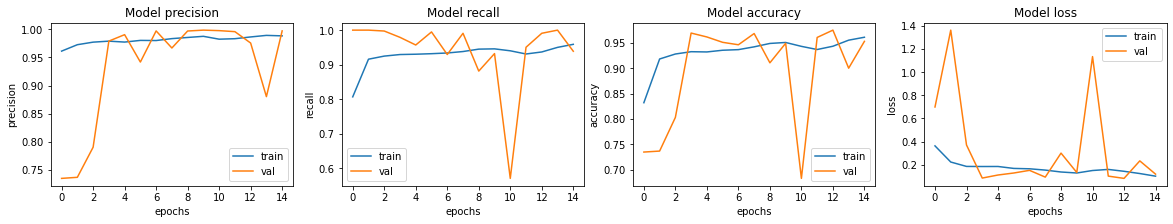

In [18]:
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [19]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \n Accuracy: {accuracy}, \n Precision: {precision}, \n Recall: {recall}')

39/39 [==============================] - 5s 122ms/step - loss: 0.4209 - accuracy: 0.8622 - precision: 0.8393 - recall: 0.9641
Loss: 0.42088058590888977, 
 Accuracy: 0.8621794581413269, 
 Precision: 0.8392857313156128, 
 Recall: 0.964102566242218
